In [17]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax.scipy.interpolate import RegularGridInterpolator

import jaxgym.components as comp

from scipy.ndimage import rotate
from scipy.ndimage import zoom, center_of_mass
import json

from scipy.optimize import curve_fit

%matplotlib widget
jax.config.update('jax_platform_name', 'cpu')


In [18]:
from libertem_ui.windows.imaging import VirtualDetectorWindow
import libertem.api as lt
ctx = lt.Context.make_with("inline")
ds = ctx.load("npy", "./fourdstem_array_0.5.npy")

In [19]:
v_window = VirtualDetectorWindow.using(ctx, ds)
v_window.layout()

BokehModel(combine_events=True, render_bundle={'docs_json': {'7c129343-99fc-4b80-b603-a6bd615f85b1': {'version…

In [20]:
#from libertem_ui.windows.com import CoMImagingWindow
#com_window = CoMImagingWindow.using(ctx, ds)
#com_window.layout()

In [21]:
sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = np.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

# Set up grid coordinates corresponding to the physical centers of the pixels.
# Note: We use the rotated image’s physical edge lengths (sample_rotated_edge_length_x/y)
# to generate coordinates that match each pixel center.
sample_coords_x = np.linspace(-sample_rotated_edge_length_x/2,
                              +sample_rotated_edge_length_x/2,
                              sample_rotated.shape[1])

sample_coords_y = np.linspace(-sample_rotated_edge_length_y/2,
                              +sample_rotated_edge_length_y/2,
                              sample_rotated.shape[0])

# Flip the y-axis of the sample_rotated image because regular grid interpolator from jax cannot 
# handle a positive to negative grid coordinate
sample_rotated_flipped = np.flipud(sample_rotated)

# Build the RegularGridInterpolator
sample_interpolant = RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated_flipped,
    method='nearest', bounds_error=False, fill_value=0.0
)

extent = (
    sample_coords_x[0], sample_coords_x[-1],
    sample_coords_y[0], sample_coords_y[-1]
)

In [22]:
#load params.json as a dictionary
with open('params_3cls.json') as f:
    params_dict = json.load(f)

camera_lengths = params_dict['camera_length']

Loop through the three camera lengths, create a model for each, and create a dataset of 
scan positions (x_ins, y_ins), known distances from sample to detector (Bs), and find the centre of mass to determine the detector positions (x_dets, y_dets)

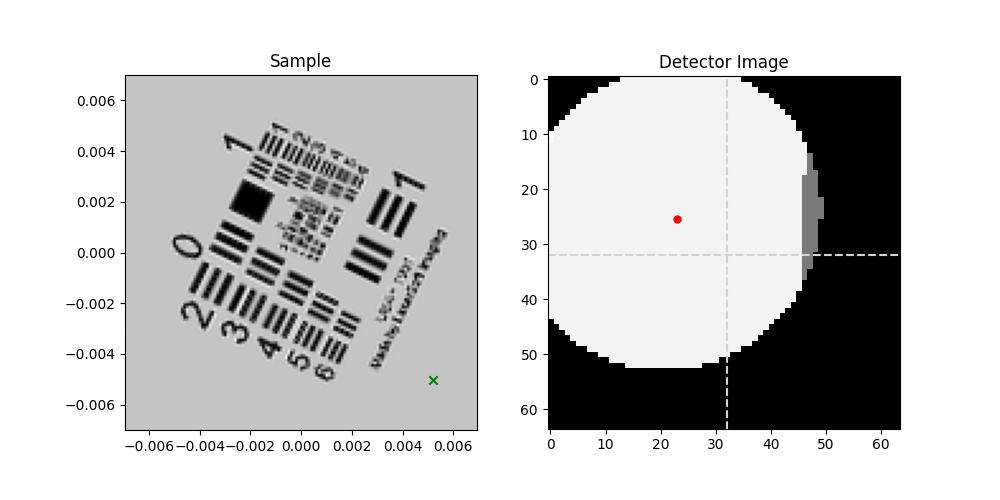

In [23]:
x_ins = []
y_ins = []
Bs = []
x_dets = []
y_dets = []

for camera_length in camera_lengths:

    crossover_z = jnp.zeros((1))
    ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_step'], scan_shape=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])
    scan_coordinates = ScanGrid.coords
    Detector = comp.Detector(z=jnp.array(camera_length), det_shape=params_dict['det_shape'], det_pixel_size=params_dict['det_px_size'], flip_y=params_dict['flip_y'])
    
    # Load the fourdstem array for the current camera length
    fourdstem_array = np.load(f'fourdstem_array_{camera_length}.npy')
    
    # Scan positions
    x_in, y_in = scan_coordinates[:, 0], scan_coordinates[:, 1]
    x_ins.append(x_in)
    y_ins.append(y_in)

    # Set the distance from the sample to the detector. 
    B = camera_length - params_dict['defocus']
    B = np.ones_like(x_in) * B
    Bs.append(B)

    # Reshape and loop through the fourdstem array
    fourdstem_array = fourdstem_array.reshape(ScanGrid.scan_shape[0] * ScanGrid.scan_shape[1], *Detector.det_shape)
    for image in fourdstem_array:

        # apply a threshold to the image and binarize
        image = np.where(np.abs(image) > 0.0, 1.0, 0.0)

        yx_px_det = center_of_mass(np.abs(image))

        xy_det = Detector.pixels_to_metres(yx_px_det)
        x_det, y_det = xy_det[0], xy_det[1]
        x_dets.append(float(x_det))
        y_dets.append(float(y_det))

# Plot the centre of mass on an image to see if it makes sense. 

fourdstem_array = fourdstem_array.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], *Detector.det_shape)
scan_idx_x, scan_idx_y = -1, -1
scan_coords = scan_coordinates.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)
scan_pos_x, scan_pos_y = scan_coords[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray', origin='upper')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray', origin='upper')
ax[1].plot(yx_px_det[1], yx_px_det[0], 'ro', markersize=5)
ax[1].axhline(Detector.det_shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.det_shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()


Display the equation we will fit

In [24]:
import sympy as sp
from sympy import symbols, Matrix

x_in, y_in, dx_in, dy_in = symbols('x_in y_in dx_in dy_in')
x_det, y_det, dx_det, dy_det = symbols('x_det y_det dx_det dy_det')

ray_in = Matrix([[x_in], [y_in], [dx_in], [dy_in]])
ray_out = Matrix([[x_det], [y_det], [dx_det], [dy_det]])

# Descan error matrix elements (position only)
Axx_dp, Axy_dp, Ayx_dp, Ayy_dp = symbols('A_{xx\\_dpos} A_{xy\\_dpos} A_{yx\\_dpos} A_{yy\\_dpos}')
Bxx_cl, Bxy_cl, Byx_cl, Byy_cl = symbols('B_{xx\\_cl} B_{xy\\_cl} B_{yx\\_cl} B_{yy\\_cl}')
Cxx_ds, Cxy_ds, Cyx_ds, Cyy_ds = symbols('C_{xx\\_dslope} C_{xy\\_dslope} C_{yx\\_dslope} C_{yy\\_dslope}')

descan_error_matrix = Matrix([[Axx_dp, Axy_dp, 0, 0],
                              [Ayx_dp, Ayy_dp, 0, 0],
                              [Cxx_ds, Cxy_ds, 1, 0],
                              [Cyx_ds, Cyy_ds, 0, 1]])

camera_length_prop_matrix = Matrix([[1, 0, Bxx_cl, 0],
                                    [0, 1, 0, Byy_cl],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]])

print('Transfer Matrix from sample to detector:')
T = camera_length_prop_matrix * descan_error_matrix
display(T)

print('Transfer Equation with input slope of rays set to 0.0 (i.e finding the central ray of the point source through the system)')
eq = sp.Eq(ray_out, T * ray_in)

# set dx_in and dy_in to 0.0
eq = eq.subs({dx_in: 0.0, dy_in: 0.0})

# Display the x_det and y_det equations independently by extracting the first two rows of the transfer matrix
eq_x = sp.Eq(x_det, eq.rhs[0])
eq_y = sp.Eq(y_det, eq.rhs[1])


Transfer Matrix from sample to detector:


Matrix([
[A_{xx\_dpos} + B_{xx\_cl}*C_{xx\_dslope}, A_{xy\_dpos} + B_{xx\_cl}*C_{xy\_dslope}, B_{xx\_cl},          0],
[A_{yx\_dpos} + B_{yy\_cl}*C_{yx\_dslope}, A_{yy\_dpos} + B_{yy\_cl}*C_{yy\_dslope},          0, B_{yy\_cl}],
[                          C_{xx\_dslope},                           C_{xy\_dslope},          1,          0],
[                          C_{yx\_dslope},                           C_{yy\_dslope},          0,          1]])

Transfer Equation with input slope of rays set to 0.0 (i.e finding the central ray of the point source through the system)


Fit the datasets with a least squares fit. 

In [25]:
def model_x(vars, Axx_dpos, Cxx_dslope, Axy_dpos, Cxy_dslope):
    xin, yin, Bxx = vars
    return xin*(Axx_dpos + Bxx*Cxx_dslope) + yin*(Axy_dpos + Bxx*Cxy_dslope)

def model_y(vars, Ayx_dpos, Cyx_dslope, Ayy_dpos, Cyy_dslope):
    xin, yin, Byy = vars
    return xin*(Ayx_dpos + Byy*Cyx_dslope) + yin*(Ayy_dpos + Byy*Cyy_dslope)

x_ins = np.array(x_ins).flatten()
y_ins = np.array(y_ins).flatten()
Bxx_cl = np.array(Bs).flatten()
Byy_cl = np.array(Bs).flatten()
x_dets = np.array(x_dets).flatten()
y_dets = np.array(y_dets).flatten()

# Take only N random samples from the data
num_samples = 100
indices = np.random.choice(len(x_ins), num_samples, replace=False)
x_ins = x_ins[indices]
y_ins = y_ins[indices]
Bxx_cl = Bxx_cl[indices]
Byy_cl = Byy_cl[indices]
x_dets = x_dets[indices]
y_dets = y_dets[indices]

popt_x, pcov_x = curve_fit(model_x, (x_ins, y_ins, Bxx_cl), x_dets, p0=np.zeros(4))
Axx_dpos, Cxx_dslope, Axy_dpos, Cxy_dslope = popt_x

popt_y, pcov_y = curve_fit(model_y, (x_ins, y_ins, Byy_cl), y_dets, p0=np.zeros(4))
Ayx_dpos, Cyx_dslope, Ayy_dpos, Cyy_dslope = popt_y

print("\nFit ABCD Values (with 5-sigma error):")
print(f"Axx_dpos = {Axx_dpos:.2f} ± {5*np.sqrt(pcov_x[0,0]):.2e}  Cxx_dslope = {Cxx_dslope:.2f} ± {5*np.sqrt(pcov_x[1,1]):.2e}")
print(f"Axy_dpos = {Axy_dpos:.2f} ± {5*np.sqrt(pcov_x[2,2]):.2e}  Cxy_dslope = {Cxy_dslope:.2f} ± {5*np.sqrt(pcov_x[3,3]):.2e}")
print(f"Ayx_dpos = {Ayx_dpos:.2f} ± {5*np.sqrt(pcov_y[0,0]):.2e}  Cyx_dslope = {Cyx_dslope:.2f} ± {5*np.sqrt(pcov_y[1,1]):.2e}")
print(f"Ayy_dpos = {Ayy_dpos:.2f} ± {5*np.sqrt(pcov_y[2,2]):.2e}  Cyy_dslope = {Cyy_dslope:.2f} ± {5*np.sqrt(pcov_y[3,3]):.2e}")


Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy = params_dict['descan_error']
print("\nActual ABCD Values:")
print(f"Axx_dpos = {Axx:.2f}  Cxx_dslope = {Cxx:.2f}")
print(f"Axy_dpos = {Axy:.2f}  Cxy_dslope = {Cxy:.2f}")
print(f"Ayx_dpos = {Ayx:.2f}  Cyx_dslope = {Cyx:.2f}")
print(f"Ayy_dpos = {Ayy:.2f}  Cyy_dslope = {Cyy:.2f}")


Fit ABCD Values (with 5-sigma error):
Axx_dpos = 7.84 ± 2.73e-01  Cxx_dslope = -9.72 ± 2.61e-01
Axy_dpos = 12.13 ± 3.02e-01  Cxy_dslope = -6.20 ± 2.87e-01
Ayx_dpos = -14.00 ± 9.61e-02  Cyx_dslope = 9.99 ± 9.22e-02
Ayy_dpos = 5.98 ± 1.06e-01  Cyy_dslope = -7.96 ± 1.01e-01

Actual ABCD Values:
Axx_dpos = 8.00  Cxx_dslope = -10.00
Axy_dpos = 12.00  Cxy_dslope = -6.00
Ayx_dpos = -14.00  Cyx_dslope = 10.00
Ayy_dpos = 6.00  Cyy_dslope = -8.00
